# Modeling
This python notebook performs regressions on data pulled from a processed mongo DB created by GASpy. It then saves these regressions into pickles (for later use) and creates parity plots of the regression fits.

Execution times vary depending on the size of the dataset and type of regression that you do. The regression illustrated here takes about 5 minutes to run. The predictions illustrated here will take about 16-24 hours to run (apiece). We use a separate script that uses 32 threads to do the prediction, which takes only 30-45 minutes to run (apiece).

# Initialize

In [1]:
# Modify the path so that we use GASpy_dev instead of GASpy
gaspy_path = '/global/project/projectdirs/m2755/GASpy/'

In [2]:
# Modify the path so that we use GASpy_dev instead of GASpy
#import sys
#gaspy_path = '/global/project/projectdirs/m2755/GASpy_dev/'
#sys.path.insert(0, gaspy_path)
#sys.path.insert(0, gaspy_path + '/GASpy_feedback')
#sys.path.insert(0, gaspy_path + '/GASpy_regressions')

In [3]:
# Importing
import pdb
from gaspy_regress.regressor import GASpyRegressor
from gaspy_regress import gio, plot, predict
from gaspy.utils import vasp_settings_to_str, read_rc, docs_to_pdocs
from gaspy import defaults

VASP_SETTINGS = vasp_settings_to_str({'gga': 'RP',
                                      'pp_version': '5.4',
                                      'encut': 350})

# Regress

In [4]:
import copy
from tpot import TPOTRegressor

In [5]:
model_name = 'TPOT'
features = ['coordatoms_chemfp0', 'neighbors_chemfp0']
responses = ['energy']
blocks = ['adsorbate']

In [ ]:
tpot = TPOTRegressor(
                     generations=1,
                     population_size=16,
                     offspring_size=16,
                     verbosity=2,
                     random_state=42,
                     scoring='neg_median_absolute_error',
                     n_jobs=16,
                    )

H = GASpyRegressor(features=features, responses=responses,
                   blocks=blocks, vasp_settings=VASP_SETTINGS,
                   dim_red='pca', #n_components='mle', svd_solver='full',
                   #train_size=0.8, dev_size=0.1)
                   #train_size=0.9)
                   train_size=1)

fit_blocks = [('CO',), ('H',)]
#fit_blocks = [('CO',)]
#fit_blocks = None

H.fit_tpot(tpot, model_name=model_name, blocks=fit_blocks)

In [ ]:
gio.dump_model(H)

In [6]:
H = gio.load_model(model_name, features, responses, blocks)

In [7]:
H.print_performance_metric('RMSE')

RMSE values:
	('H',)
		all
			0.264244281218
		train
			0.264244281218
	('CO',)
		all
			0.146283448047
		train
			0.146283448047


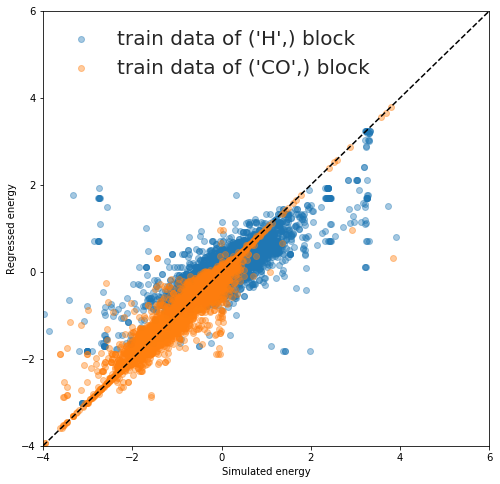

In [10]:
x, y, text = H.parity_plot(plotter='matplotlib', figsize=(8, 8), alpha=0.4)

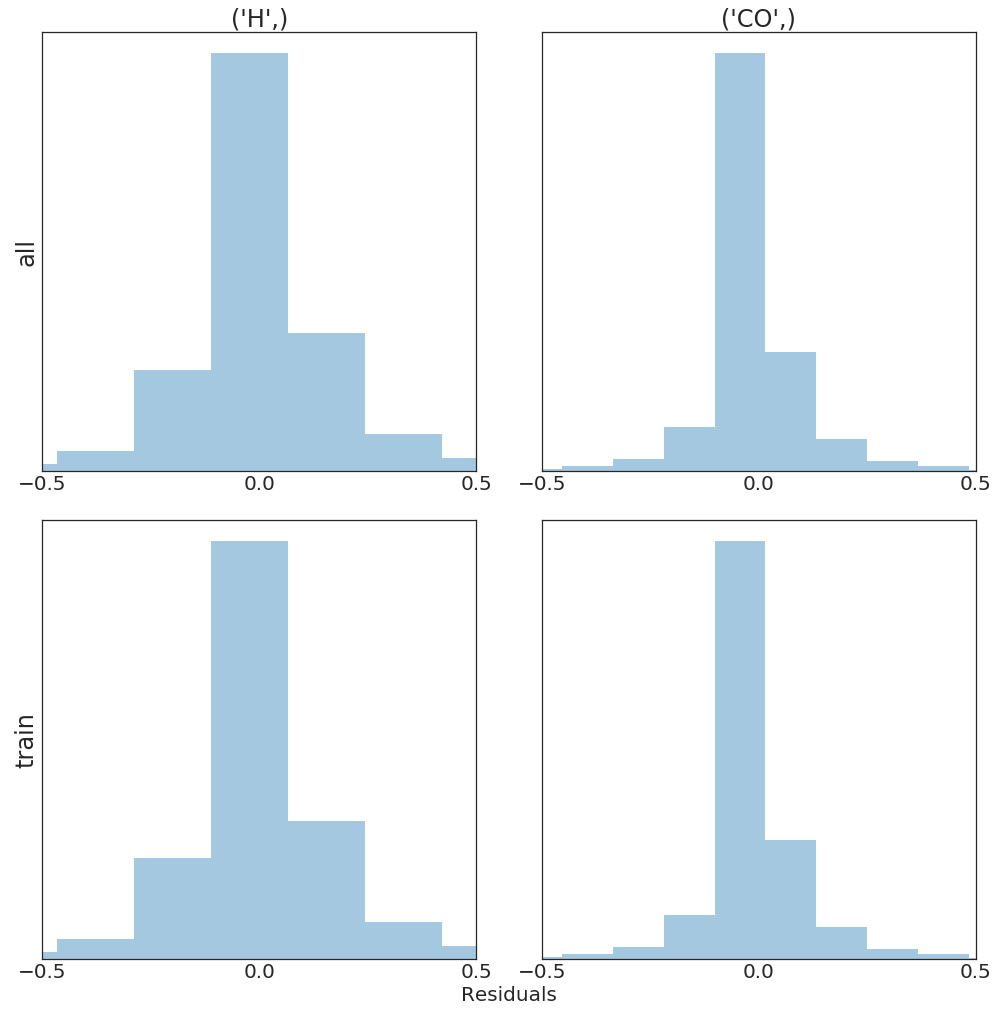

In [11]:
H.residual_plot(xlim=[-0.5, 0.5], xticks=[-0.5, 0, 0.5])

# Predict

## CO$_2$ Reduction

In [12]:
regressor_block = ('CO',)
adsorbate = 'CO'
system = 'CO2RR'
scale = 'log'

In [ ]:
co2_data = predict.volcano(H, regressor_block, system,excel_file_path,
                           scale, adsorbate, processes=4)

In [ ]:
gio.dump_predictions(co2_data, regressor=H, system=system)

In [13]:
co2_data = gio.load_predictions(model_name, features, responses, blocks, system)

In [ ]:
plot.volcano(co2_data, excel_file_path, system, scale)

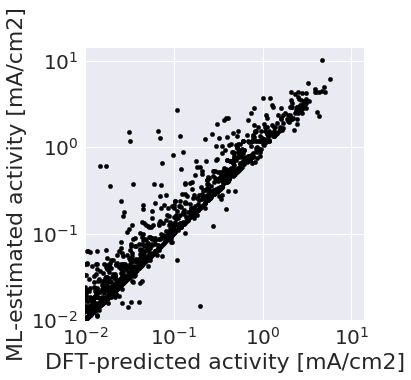

In [14]:
plot.filtered_parity(co2_data, scale=scale, plot_type='matplotlib', plot_range=[0.01, 14],
                     x_label='DFT-predicted activity [mA/cm2]',
                     y_label='ML-estimated activity [mA/cm2]',
                     title='Activity on surface minima')

In [ ]:
plot.filtered_parity(co2_data, scale=scale, plot_type='plotly', plot_range=[0.01, 14],
                     x_label='DFT-predicted activity [mA/cm2]',
                     y_label='ML-estimated activity [mA/cm2]',
                     title='Activity on surface minima')

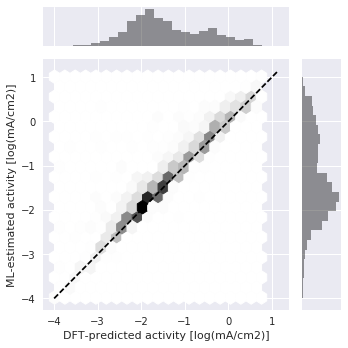

In [15]:
plot.filtered_parity(co2_data, scale=scale, plot_type='hex', plot_range=[0.0001, 14],
                     save=True,
                     x_label='DFT-predicted activity [log(mA/cm2)]',
                     y_label='ML-estimated activity [log(mA/cm2)]',
                     title='Activity parity on surface minima')

## HER

In [16]:
regressor_block = ('H',)
adsorbate = 'H'
system = 'HER'
scale = 'log'

In [ ]:
her_data = predict.volcano(H, regressor_block, system, excel_file_path, scale, adsorbate)

In [ ]:
gio.dump_predictions(her_data, regressor=H, system=system)

In [17]:
her_data = gio.load_predictions(model_name, features, responses, blocks, system)

In [ ]:
plot.volcano(her_data, excel_file_path, system, scale)

In [ ]:
plot.filtered_parity(her_data, scale=scale, plot_type='plotly', plot_range=[1e-12, 1e-3],
                     x_label='DFT-predicted activity [A/cm2]',
                     y_label='ML-estimated activity [A/cm2]',
                     title='Activity on surface minima')

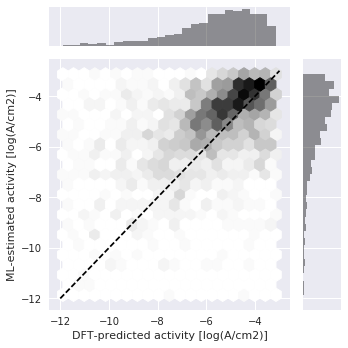

In [18]:
plot.filtered_parity(her_data, scale=scale, plot_type='hex', plot_range=[1e-12, 1e-3],
                     x_label='DFT-predicted activity [log(A/cm2)]',
                     y_label='ML-estimated activity [log(A/cm2)]',
                     title='Activity parity on surface minima')